In [15]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

In [2]:
# Read in cars and notcars
# Read in our vehicles and non-vehicles
dir = './non-vehicles/**/*.png'

#images = glob.glob('*.jpeg')
images = glob.glob(dir)
cars = []
notcars = []


for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
#    else:
#        cars.append(image)

print(len(notcars))

cardir = './vehicles/**/*.png'

#images = glob.glob('*.jpeg')
carimages = glob.glob(cardir)

for image in carimages:
    cars.append(image)
    
print(len(cars))

8968
8792


In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


"""
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
"""

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), hog_channel = 'ALL'):
    # Create a list to append feature vectors to
    
    pix_per_cell=8
    cell_per_block=2
    orient=9
    
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        
        
                # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
#        features.append(hog_features)
        """      
        print('spatial_features')
        print(type(spatial_features))
        print('hist_features')
        print(type(hist_features))
        print('hog_features ')
        print(type(hog_features))
        """ 
    
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features

In [4]:
spatial = 16
histbin = 16
orient=9
#cspace='HSV'
cspace='HLS'
#cspace='RGB'

pix_per_cell=8
cell_per_block=2
spatial_size = (spatial,spatial)
hist_bins = histbin

In [5]:
car_features = extract_features(cars, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), hog_channel = 'ALL')
notcar_features = extract_features(notcars, cspace=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),hog_channel = 'ALL')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Using spatial binning of: 16 and 16 histogram bins
Feature vector length: 6108
14.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9882
My SVC predicts:  [ 0.  1.  1.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  1.  1.  1.  0.]
0.00135 Seconds to predict 10 labels with SVC


In [6]:
print(car_features[:1])
print(np.array(car_features[:1]).shape)
print(scaled_X[:1])

[array([  7.32476807e+01,   7.74521408e+01,   1.10491074e+02, ...,
         1.16554285e-02,   0.00000000e+00,   5.48860982e-03])]
(1, 6108)
[[-0.69103607 -0.64771542 -0.24216637 ..., -0.34258103 -1.12385176
  -0.63512514]]


In [35]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)


def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox_list = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HLS')
#    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
#    print(ch1.shape[0])
#    print(ch1.shape[1])

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    
#    print(ch1.shape[1])
#    print(pix_per_cell)
    
#    print("ch1.shape[1] // pix_per_cell : %s  " % (ch1.shape[1] // pix_per_cell))
    

    
    
#    nxblocks = (ch1.shape[1] // pix_per_cell)
#    nyblocks = (ch1.shape[0] // pix_per_cell) 
    
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    
    nblocks_per_window = (window // pix_per_cell)-1 
    
    print(" nblocks_per_window : %s  " %  nblocks_per_window)
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    print("nxblocks : %s  " % nxblocks)
    print("nyblocks : %s  " % nyblocks)
    print("nxsteps : %s  " % nxsteps)
    print("nysteps : %s  " % nysteps)

    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    print(type(hog1))
    print(hog1.shape)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
      #      print("ypos is %s " % ypos)
            
            xpos = xb*cells_per_step
      #      print("xpos is %s " % xpos)
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
             # Assuming each "box" takes the form ((x1, y1), (x2, y2))
 #           heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
 #               bbox_list.append((top_left, bottom_right))
                """
                print("xbox_left %s " % str(xbox_left))
                print("ytop_draw+ystart %s" % str(ytop_draw+ystart))
                print("xbox_left+win_draw %s" % str(xbox_left+win_draw))
                print("ytop_draw+win_draw+ystart %s" % str(ytop_draw+win_draw+ystart))
                
                print("win_draw %s" % str(win_draw))
                """
                top_left = (xbox_left, ytop_draw+ystart)
                bottom_right = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                bbox_list.append((top_left, bottom_right))
        
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bbox_list

In [36]:
ystart = 400
ystop = 656
scale = 1.5

#img = mpimg.imread('bbox-example-image.jpg')

img = mpimg.imread('test_images/test1.jpg')

out_img, bbox_list = find_cars(img, 
                    ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins)

 nblocks_per_window : 7  
nxblocks : 105  
nyblocks : 20  
nxsteps : 49  
nysteps : 6  
<class 'numpy.ndarray'>
(20, 105, 2, 2, 9)


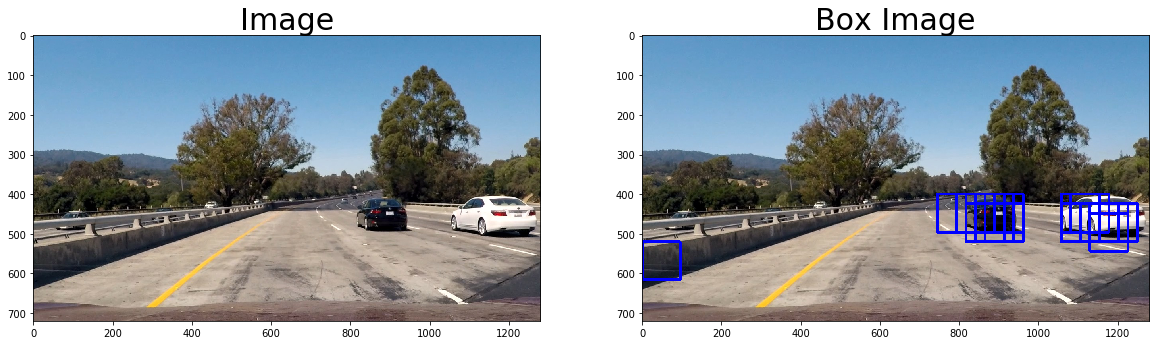

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Image', fontsize=30)
ax2.imshow(out_img)
ax2.set_title('Box Image', fontsize=30)
#plt.imshow(out_img)

 nblocks_per_window : 7  
nxblocks : 105  
nyblocks : 20  
nxsteps : 49  
nysteps : 6  
<class 'numpy.ndarray'>
(20, 105, 2, 2, 9)


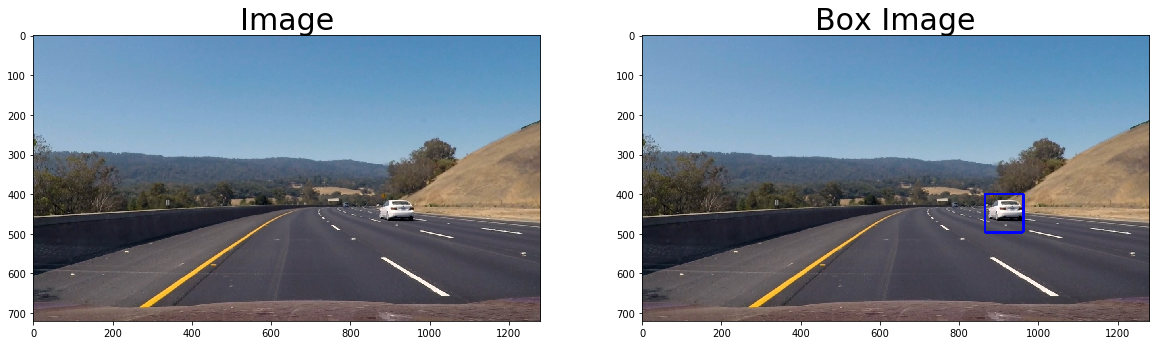

In [10]:
img = mpimg.imread('test_images/test3.jpg')

out_img = find_cars(img, 
                    ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Image', fontsize=30)
ax2.imshow(out_img)
ax2.set_title('Box Image', fontsize=30)
#plt.imshow(out_img)

 nblocks_per_window : 7  
nxblocks : 105  
nyblocks : 20  
nxsteps : 49  
nysteps : 6  
<class 'numpy.ndarray'>
(20, 105, 2, 2, 9)


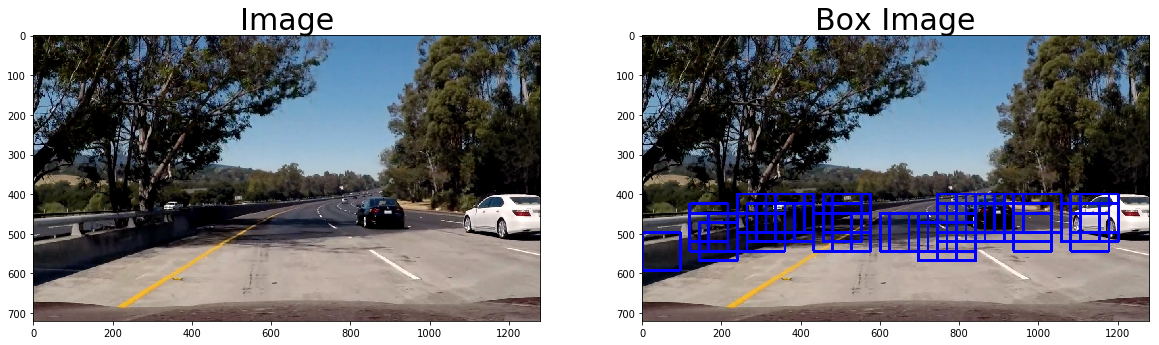

In [11]:
img = mpimg.imread('test_images/test5.jpg')

out_img = find_cars(img, 
                    ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Image', fontsize=30)
ax2.imshow(out_img)
ax2.set_title('Box Image', fontsize=30)
#plt.imshow(out_img)

 nblocks_per_window : 7  
nxblocks : 105  
nyblocks : 20  
nxsteps : 49  
nysteps : 6  
<class 'numpy.ndarray'>
(20, 105, 2, 2, 9)


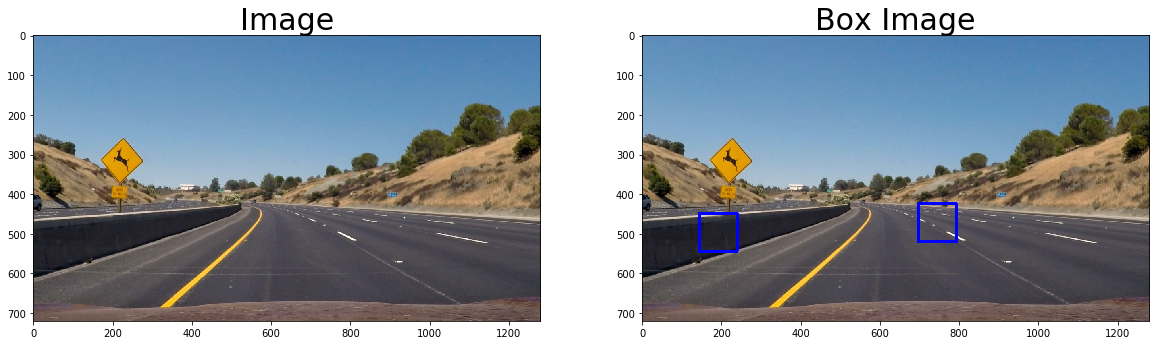

In [12]:
img = mpimg.imread('test_images/test2.jpg')

out_img = find_cars(img, 
                    ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Image', fontsize=30)
ax2.imshow(out_img)
ax2.set_title('Box Image', fontsize=30)
#plt.imshow(out_img)

 nblocks_per_window : 7  
nxblocks : 105  
nyblocks : 20  
nxsteps : 49  
nysteps : 6  
<class 'numpy.ndarray'>
(20, 105, 2, 2, 9)


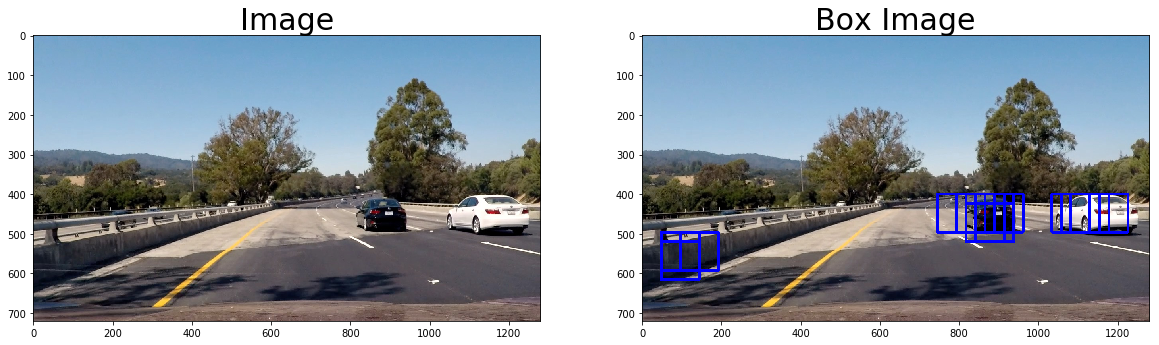

In [13]:
img = mpimg.imread('test_images/test4.jpg')

out_img = find_cars(img, 
                    ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatial_size, hist_bins)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Image', fontsize=30)
ax2.imshow(out_img)
ax2.set_title('Box Image', fontsize=30)
#plt.imshow(out_img)

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [39]:
image = img
box_list = bbox_list

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)


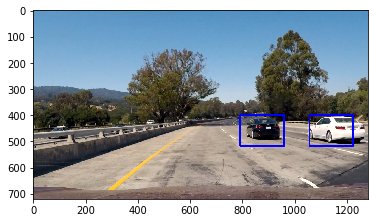

In [41]:
print(labels)
plt.imshow(draw_img)